In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import os
import tensorflow
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import cv2

tensorflow.random.set_seed(123)

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"


# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv0 (Conv2D)              (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv1 (Conv2D)              (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2 (Conv2D)              (None, 7, 7, 64)          18496 

313/313 [==============================] - 0s 1ms/step - loss: 0.0522 - accuracy: 0.9835
5799
[12, 9, 43]


([<matplotlib.axis.XTick at 0x7fdda80cdcd0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

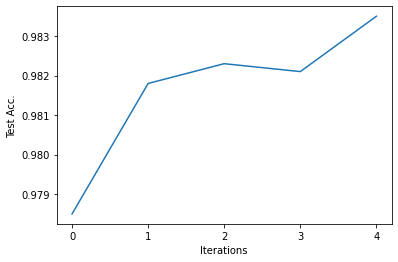

In [7]:
from sklearn.cross_decomposition import PLSRegression
import pandas as pd
import numpy as np


def get_absolute_rank(model,layer_names, p):
    scores = []
    for l in layer_names:
        nf = model.get_layer(l).weights[0].shape[-1]
        scores.extend(np.mean(np.abs(model.get_layer(l).weights[0].numpy()).reshape([-1,nf]), axis=0))
    
    idx = np.argsort(scores)[::-1][:int(len(scores)*(1-p))]
    
    return idx

def get_importance_rank(model, x_train, y_train, p):
    # getting the feature representation for all training samples
    c1, c2, c3 = model.predict(x_train)
    
    # concatenating
    filters_response = np.concatenate([c1,c2,c3], axis=-1)
    
    # fitting the PLS model
    pls2 = PLSRegression(n_components=2)
    pls2.fit(filters_response, np.argmax(y_train, axis=1))
    
    # computing the vip score
    vip_scores = vip(pls2)
    
    # the filters that we want to keep
    idx = np.argsort(vip_scores)[::-1][:int(len(vip_scores)*(1-p))]
    
    return idx

def get_output_names(multiple_model):
    output_names = []
    for idx,l in enumerate(multiple_model.outputs):
        output_names.extend(['conv%d_%d' % (idx,ni) for ni in np.arange(l.shape[1])])

    output_names = np.array(output_names)
    return output_names

# computing the PLS Vip importance
def vip(model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_
    p, h = w.shape
    vips = np.zeros((p,))
    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)
    return vips

def get_model(input_shape, num_classes, num_filters, mode = 'max'):
    
    # Model
    img = keras.Input(shape=input_shape)
    x = img
    conv_outs = []
    for idx,f in enumerate(num_filters):
        x1 = layers.Conv2D(f, kernel_size=(3, 3), activation="relu", name = "conv%d" % idx, padding="same")(x) # , kernel_regularizer = keras.regularizers.l1_l2(l1=0.0001, l2=0.0001)
        x = layers.MaxPooling2D(2)(x1)
        if mode == 'max':
            x1 = layers.GlobalMaxPooling2D()(x1)
        if mode == 'avg':
            x1 = layers.GlobalAveragePooling2D()(x1)
            
        conv_outs.append(x1)
    

    x = layers.Dropout(0.5, name = "dropout")(x1)
    out = layers.Dense(num_classes, activation="softmax",  name = "dense")(x)
    
    model = keras.Model(inputs = img, outputs = out)

    multiple_model = keras.Model(inputs = img, outputs = conv_outs)
    
    return model, multiple_model


# paramters
batch_size = 128
epochs = 10
# percentage of filters to remove at each iteration
p = 0.1 
# number of filters at each layer
initial_filters = [16, 32, 64]

# global pooling before pls
mode = 'avg' # 'max'

# num iterations
num_iters = 5

# method (PLS or ABS)
method = 'pls' #'abs'
filters_conv = initial_filters

weights = {}
layer_names = ['conv0', 'conv1', 'conv2']
acc_test = []


for iters in np.arange(num_iters):
    
    model, multiple_model = get_model(input_shape, num_classes, num_filters = filters_conv, mode = mode)
    model.summary()
    
    if len(weights) > 0:
        for l in layer_names:
            model.get_layer(l).set_weights(weights[l]['weights'])
            multiple_model.get_layer(l).set_weights(weights[l]['weights'])
        
        model.get_layer('dense').set_weights(weights['dense']['weights'])
        weights = {}
        
    # training the model
    if iters == 0:
        opt = tensorflow.keras.optimizers.Adam(learning_rate=0.01)
        model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
        model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose = 0)
    else:
        opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        model.fit(x_train, y_train, batch_size=batch_size, epochs=2, validation_split=0.1, verbose = 0)
        
    # evaluating the model
    out_eval = model.evaluate(x_test, y_test)
    acc_test.append(out_eval[1])
    
    num_filters_layer = []
    
    # computing the PLS VIP importance
    
    output_names = get_output_names(multiple_model)
    if method == 'pls':
        idx = get_importance_rank(multiple_model, x_train, y_train, p)
    elif method == 'abs':
        idx =  get_absolute_rank(model,layer_names, p)
    
        
    lnames = np.array([l.split('_')[0] for l in output_names[idx]])
    lpos = np.array([int(l.split('_')[1]) for l in output_names[idx]])
    
    prev_layer = [0]
    for layer in layer_names:

        w, b = model.get_layer(layer).get_weights()[0], model.get_layer(layer).get_weights()[1]
        
        num_filters_layer.append(np.sum(lnames == layer))
        weights[layer] = {}
        actual_layer = lpos[lnames == layer]
        weights[layer]['weights'] = [w[:, : , prev_layer, :][:,:,:, actual_layer], b[actual_layer]]   
        prev_layer = lpos[lnames == layer]
    
    print(model.count_params())
    weights['dense'] = {}
    weights['dense']['weights'] = [model.get_layer('dense').get_weights()[0][prev_layer,:], model.get_layer('dense').get_weights()[1]]
    
    filters_conv = list(num_filters_layer)


    print(filters_conv)
    del model
    del multiple_model
    
    K.clear_session()
    
plt.plot(acc_test)
plt.xlabel('Iterations')
plt.ylabel('Test Acc.')
plt.xticks(np.arange(len(acc_test)))

In [ ]:
!pip install pydot